In [2]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

In [3]:
N_sim = int(1e5)
dt = 1e-3
T_max = 2
dB = np.sqrt(dt)

DV_vs_t = np.zeros((N_sim, int(T_max/dt)))


v = 1; a = 2

In [4]:
for n in tqdm(range(N_sim)):
    t = 0
    DV = 0
    for i in range(1,int(T_max/dt)):
        t += dt
        DV += v*dt + np.random.normal(0, dB)
        DV_vs_t[n, int(t/dt)] = DV
        if DV >= a:
            break
        

100%|██████████| 100000/100000 [01:21<00:00, 1230.09it/s]


In [5]:
t = 0.05
t_bin = int(t/dt)

In [6]:
def theory_curve(x,t,v,a):
    return (1/np.sqrt(2 * (np.pi**2) * t)) * \
        ( np.exp(-((x - v*t)**2)/2*t) - np.exp( 2*v*a - ((x - 2*a - v*t)**2)/(2*t) ) )

In [8]:
import numpy as np

def diffusion_pdf(x, t, v, D, a, num_terms=100):
    """
    Calculate the PDF of a diffusion process with drift and absorbing boundaries.

    Parameters:
    x (float): Position at which to evaluate the PDF.
    t (float): Time at which to evaluate the PDF.
    v (float): Drift velocity.
    D (float): Diffusion coefficient.
    a (float): Length of the interval [0, a].
    num_terms (int): Number of terms to include in the series approximation.

    Returns:
    float: The value of the PDF at position x and time t.
    """
    if x < 0 or x > a or t <= 0:
        return 0.0

    pdf_value = 0.0
    for n in range(1, num_terms + 1):
        lambda_n = n * np.pi / a
        k_n = (v / (2 * D))**2 + (lambda_n**2)
        A_n = 2 / a * np.sin(lambda_n * x)
        term = A_n * np.exp(-D * k_n * t + (v * x) / (2 * D))
        pdf_value += term

    return pdf_value


In [7]:
from scipy.integrate import quad
quad(theory_curve, -10, 3, args=(t,v,a))[0]

8.270363379154869

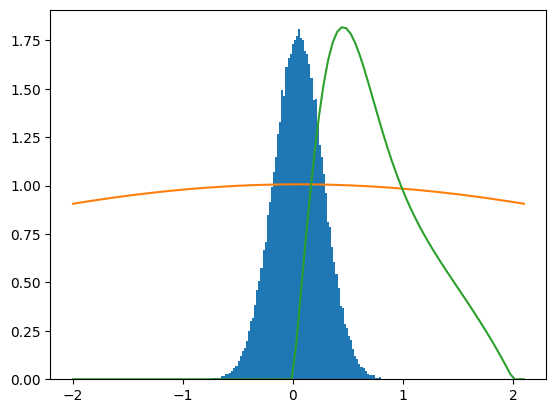

In [12]:
P_x_at_t = DV_vs_t[:,t_bin]
# remove zeros from P_x_at_t 
# P_x_at_t = P_x_at_t[P_x_at_t != 0]
plt.hist(P_x_at_t, bins=100, density=True);

x_pts = np.linspace(-2, 2.1, 100)
theory = [theory_curve(x, t, v, a) for x in x_pts]
plt.plot(x_pts, theory)

new_theory = [diffusion_pdf(x, t, v, 1, a) for x in x_pts]
plt.plot(x_pts, new_theory)